In [1]:
import numpy as np
import _pickle as cPickle
import os
import gzip
import matplotlib.pyplot as plt
from tqdm import tqdm


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# First exercise: Classifying MNIST with MLPs
In this exercise you will implement a Neural Network (or MLP) and classify the MNIST digits with it.
MNIST is a "well hung" dataset that has been used a lot over the years to benchmark different classification algorithms. 
To learn more about it have a look here: http://yann.lecun.com/exdb/mnist/ .

# Data Loading
We first define a function for downloading and loading MNIST.
**WARNING**: Executing it will obviously use up some space on your machine ;). 

In [2]:
def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = cPickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = cPickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    return rval

# Neural Network Layers
We now define "bare bone" neural network layers.
The parts marked with **TODO** are where you should finish the implementation!
Conceptually we will implement the layers as follows:

Each layer has a constructor that takes an input layer plus some additional arguments such as layer size and the activation function name. The layer then uses the provided input layer to compute the layer dimensions, weight shapes, etc. and setup all auxilliary variables.

Each layer then has to provide three functions (as defined in the Layer class below): *output_shape()*, *fprop()* and *brop()*. The output_shape function is used to figure out the shape for the next layer and the *fprop()/bprop()* functions are used to compute forward and backward passes through the network.

In [3]:
# start by defining simple helpers
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoid_d(x):
    # the derivate of the sigmoid function wrt to its input is simply sigmoid(x)*(1-sigmoid(x))
    tmp = sigmoid(x)
    return tmp * (1 - tmp)

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    # the derivative of the tanh function is 1-tanh²(x)
    tmp = tanh(x)
    return 1 - tmp * tmp

def relu(x):
    return np.maximum(0.0, x)

def relu_d(x):
    # the derivative of the relu function is defined as 1 for x>0 and 0 everywhere else
    grad = np.zeros(x.shape)
    grad[x>0] = 1
    return grad

def softmax(x, axis=1):
    # to make the softmax a "safe" operation we will 
    # first subtract the maximum along the specified axis
    # so that np.exp(x) does not blow up!
    # Note that this does not change the output.
    x_max = np.max(x, axis=axis, keepdims=True)
    x_safe = x - x_max
    e_x = np.exp(x_safe)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

def unhot(one_hot_labels):
    """ Invert a one hot encoding, creating a flat vector """
    return np.argmax(one_hot_labels, axis=-1)

# then define an activation function class
class Activation(object):
    
    def __init__(self, tname):
        if tname == 'sigmoid':
            self.act = sigmoid
            self.act_d = sigmoid_d
        elif tname == 'tanh':
            self.act = tanh
            self.act_d = tanh_d
        elif tname == 'relu':
            self.act = relu
            self.act_d = relu_d
        else:
            raise ValueError('Invalid activation function.')
            
    def fprop(self, input):
        # we need to remember the last input
        # so that we can calculate the derivative with respect
        # to it later on
        self.last_input = input
        return self.act(input)
    
    def bprop(self, output_grad):
        return output_grad * self.act_d(self.last_input)

# define a base class for layers
class Layer(object):
    
    def fprop(self, input):
        """ Calculate layer output for given input 
            (forward propagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def bprop(self, output_grad):
        """ Calculate input gradient and gradient 
            with respect to weights and bias (backpropagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def output_size(self):
        """ Calculate size of this layer's output.
        input_shape[0] is the number of samples in the input.
        input_shape[1:] is the shape of the feature.
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a base class for loss outputs
# an output layer can then simply be derived
# from both Layer and Loss 
class Loss(object):

    def loss(self, output, output_net):
        """ Calculate mean loss given real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def input_grad(self, output, output_net):
        """ Calculate input gradient real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a base class for parameterized things        
class Parameterized(object):
    
    def params(self):
        """ Return parameters (by reference) """
        raise NotImplementedError('This is an interface class, please use a derived instance')
    
    def grad_params(self):
        """ Return accumulated gradient with respect to params. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a container for providing input to the network
class InputLayer(Layer):
    
    def __init__(self, input_shape):
        if not isinstance(input_shape, tuple):
            raise ValueError("InputLayer requires input_shape as a tuple")
        self.input_shape = input_shape

    def output_size(self):
        return self.input_shape
    
    def fprop(self, input):
        return input
    
    def bprop(self, output_grad):
        return output_grad
        
class FullyConnectedLayer(Layer, Parameterized):
    """ A standard fully connected hidden layer, as discussed in the lecture.
    """
    
    def __init__(self, input_layer, num_units, 
                 init_stddev, activation_fun=Activation('relu')):
        self.num_units = num_units
        self.activation_fun = activation_fun
        # the input shape will be of size (batch_size, num_units_prev) 
        # where num_units_prev is the number of units in the input 
        # (previous) layer
        self.input_shape = input_layer.output_size()
        # this is the weight matrix it should have shape: (num_units_prev, num_units)
        self.W = np.random.normal(0, init_stddev, (self.input_shape[1], num_units))
        # and this is the bias vector of shape: (num_units)
        self.b = np.random.normal(0, init_stddev, num_units)
        # create dummy variables for parameter gradients
        # no need to change these here!
        self.dW = None
        self.db = None
    
    def output_size(self):
        return (self.input_shape[0], self.num_units)
    
    def fprop(self, input):
        # you again want to cache the last_input for the bprop
        # implementation below!
        self.last_input = input
        # NOTE: Use numpy dot product
        # a = W * x + b 
        output = np.dot(input, self.W) + self.b
        # h = t(a) 
        if self.activation_fun is not None:
            output = self.activation_fun.fprop(output)
            
        return output

        
    def bprop(self, output_grad):
        """ Calculate input gradient (backpropagation). """
        # HINT: you may have to divide dW and db by n
        #       to make gradient checking work 
        #       OR you divide the gradient in the output layer by n
        n = output_grad.shape[0]
        # NOTE: you should also handle the case where 
        #       activation_fun is None (meaning no activation)
        if self.activation_fun is not None:
            output_grad = self.activation_fun.bprop(output_grad)  
        # the gradient wrt. W should be stored as self.dW
        # the gradient wrt. b should be stored as self.db
        self.dW = np.dot(self.last_input.T, output_grad) * (1/n)
        self.db = np.sum(output_grad, axis=0) * (1/n)
        # the gradient wrt. the input should be calculated here
        grad_input = np.dot(output_grad, self.W.T)
        return grad_input
        
    def params(self):
        return self.W, self.b

    def grad_params(self):
        return self.dW, self.db

# finally we specify the interface for output layers 
# which are layers that also have a loss function
# we will implement two output layers:
#  a Linear, and Softmax (Logistic Regression) layer
# The difference between output layers and and normal 
# layers is that they will be called to compute the gradient
# of the loss through input_grad(). bprop will never 
# be called on them!
class LinearOutput(Layer, Loss):
    """ A simple linear output layer that  
        uses a squared loss (e.g. should be used for regression)
    """
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
        
    def fprop(self, input):
        return input

    def bprop(self, output_grad):
        raise NotImplementedError(
            'LinearOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):

        return Y_pred -Y

    def loss(self, Y, Y_pred):
        loss = 0.5 * np.square(Y_pred - Y)
        return np.mean(np.sum(loss, axis=1))

class SoftmaxOutput(Layer, Loss):
    """ A softmax output layer that calculates 
        the negative log likelihood as loss
        and should be used for classification.
    """
    
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
    
    def fprop(self, input):

        return softmax(input)
    
    def bprop(self, output_grad):
        raise NotImplementedError(
            'SoftmaxOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        
        return Y_pred - Y

    def loss(self, Y, Y_pred):
        # Assume one-hot encoding of Y
        out = Y_pred
        # to make the loss numerically stable 
        # you should add an epsilon in the log ;)
        eps = 1e-10
        loss = np.sum(-1 * np.multiply(np.log(out + eps),Y), axis=1)
        return np.mean(loss)
        

# Neural Network class
With all layers in place (and properly implemented by you) we can finally define a neural network.
For our purposes a neural network is simply a collection of layers which we will cycle through and on which we will call fprop and bprop to compute partial derivatives with respect to the input and the parameters.

Pay special attention to the *check_gradients()* function in which you should implement automatic differentiation. This function will become your best friend when checking the correctness of your implementation.

In [4]:

class NeuralNetwork:
    """ Our Neural Network container class.
    """
    def __init__(self, layers):
        self.layers = layers
        
    def _loss(self, X, Y):
        Y_pred = self.predict(X)
        return self.layers[-1].loss(Y, Y_pred)

    def predict(self, X):
        """ Calculate an output Y for the given input X. """
        Y_pred = X.copy()
        cnt = 0
        for layer in self.layers:
            Y_pred = layer.fprop(Y_pred)
            cnt+=1

        return Y_pred
    
    def backpropagate(self, Y, Y_pred, upto=0):
        """ Backpropagation of partial derivatives through 
            the complete network up to layer 'upto'
        """
        next_grad = self.layers[-1].input_grad(Y, Y_pred)
        # I need the layer indices in reversed order to know
        # when I reach the "upto" layer
        for ind in range(len(self.layers)-1)[::-1]:
            next_grad = self.layers[ind].bprop(next_grad)
            if ind == upto:
                break    
               
        return next_grad
    
    def classification_error(self, X, Y):
        """ Calculate error on the given data 
            assuming they are classes that should be predicted. 
        """
        Y_pred = unhot(self.predict(X))
        error = Y_pred != Y
        return np.mean(error)
    
    
    def sgd_epoch(self, X, Y, learning_rate, batch_size, weight_decay=0):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        for b in range(n_batches):
            # start by extracting a batch from X and Y
            X_mb = X[b * batch_size: b * batch_size + batch_size] 
            Y_mb = Y[b * batch_size: b * batch_size + batch_size]
            # TODO: then forward and backward propagation + updates
            # forward pass
            Y_pred = self.predict(X_mb)
            # backpropagation
            grad = self.backpropagate(Y_mb,Y_pred)     
            # layer.params() returns the two parameters, the first
            # element is W, the second b
            # go through all layers
            for layer in self.layers:
                if isinstance(layer, Parameterized):
                    W, b = layer.params()
                    dW, db = layer.grad_params()
                    layer.W -= learning_rate * dW + weight_decay * learning_rate * W
                    layer.b -= learning_rate * db
                                  
    
    def gd_epoch(self, X, Y, learning_rate, weight_decay=0):
        # if X contains more than 2000 samples, divide the gradient
        # process into several steps
        if X.shape[0] > 2000:
            batch_size = 1024
            num_batches = X.shape[0] // batch_size

            for b in range(num_batches):
                
                # first save the old gradients
                gradients_old = []
                for layer in self.layers:
                    if isinstance(layer, Parameterized):
                        dW_old, db_old = layer.grad_params()
                        gradients_old.append((dW_old, db_old))
                        
                X_mb = X[b * batch_size: b * batch_size + batch_size]
                Y_mb = Y[b * batch_size: b * batch_size + batch_size]
                
                Y_pred = self.predict(X_mb)
                grad = self.backpropagate(Y_mb, Y_pred)
                
                # now we have the new gradients in grad_params()
                layer_cnt = 0
                for layer in self.layers:
                    if isinstance(layer, Parameterized):
                        dW_new, db_new = layer.grad_params()
                        # our gradient should be a combination of the old 
                        # gradient and the new one, weighted by the number
                        # of samples used to compute it 
                        if dW_old is not None:
                            layer.dW = (b-1)/b * gradients_old[layer_cnt][0] + (1/b) * dW_new 
                            layer.db = (b-1)/b * gradients_old[layer_cnt][1] + (1/b) * db_new
                        layer_cnt += 1
        
        # compute gradient on whole dataset if it's not too big
        else:
            Y_pred = self.predict(X)
            grad = self.backpropagate(Y, Y_pred)
                                  
        # update parameters
        for layer in self.layers:
                if isinstance(layer, Parameterized):
                    W, b = layer.params()
                    dW, db = layer.grad_params()
                    layer.W -= learning_rate * dW + weight_decay * learing_rate * W
                    layer.b -= learning_rate * db  
                    layer.dW, layer.db = None, None
        
    
    def train(self, X, Y, X_valid, Y_valid, learning_rate=0.1, max_epochs=100, batch_size=64,
              descent_type="sgd", y_one_hot=True, weight_decay=0):

        """ Train network on the given data. """
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        # initialize lists to save the loss and error values
        train_loss_lst, train_err_lst, val_loss_lst, val_err_lst = [], [], [], []
        if y_one_hot:
            Y_train = one_hot(Y)
        else:
            Y_train = Y
        print("... starting training")
        for e in range(max_epochs+1):
            if descent_type == "sgd":
                self.sgd_epoch(X, Y_train, learning_rate, batch_size, weight_decay)
            elif descent_type == "gd":
                self.gd_epoch(X, Y_train, learning_rate, weight_decay)
            else:
                raise NotImplementedError("Unknown gradient descent type {}".format(descent_type))

            # Output error on the training data
            train_loss = self._loss(X, Y_train)
            # save train loss to list
            train_loss_lst.append(train_loss)
            train_error = self.classification_error(X, Y)
            train_err_lst.append(train_error)
            print('epoch {}, loss {:.4f}, train error {:.4f}'.format(e, train_loss, train_error))

            # compute error on validation data
            if y_one_hot:
                Y_val = one_hot(Y_valid)
            else:
                Y_val = Y_valid
            val_loss = self._loss(X_valid, Y_val)
            val_loss_lst.append(val_loss)
            val_error = self.classification_error(X_valid, Y_valid)
            val_err_lst.append(val_error)
            print('epoch {}, validation loss {:.4f}, validation error {:.4f}'.format(e, val_loss, val_error))
            
        return (train_loss_lst, train_err_lst), (val_loss_lst, val_err_lst)
    
    def check_gradients(self, X, Y):
        """ Helper function to test the parameter gradients for
        correctness. """
        for l, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):
                print('checking gradient for layer {}'.format(l))
                for p, param in enumerate(layer.params()):
                    # we iterate through all parameters
                    param_shape = param.shape
                    # define functions for conveniently swapping
                    # out parameters of this specific layer and 
                    # computing loss and gradient with these 
                    # changed parametrs
                    def output_given_params(param_new):
                        """ A function that will compute the output 
                            of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # return computed loss
                        return self._loss(X, Y)

                    def grad_given_params(param_new):
                        """A function that will compute the gradient 
                           of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # Forward propagation through the net
                        Y_pred = self.predict(X)
                        # Backpropagation of partial derivatives
                        self.backpropagate(Y, Y_pred, upto=l)
                        # return the computed gradient 
                        return np.ravel(self.layers[l].grad_params()[p])

                    # let the initial parameters be the ones that
                    # are currently placed in the network and flatten them
                    # to a vector for convenient comparisons, printing etc.
                    param_init = np.ravel(np.copy(param))
                    
                    # To debug you network's gradients use scipys
                    # gradient checking!
                    epsilon = 1e-5
                    import scipy.optimize
                    err = scipy.optimize.check_grad(output_given_params, 
                          grad_given_params, param_init) 
                    print('diff scipy {:.2e}'.format(err))
                    assert(err < epsilon)
                    
                    # reset the parameters to their initial values
                    param[:] = np.reshape(param_init, param_shape)

# Gradient Checking
After implementing everything it is always a good idea to setup some layers and perform gradient
checking on random data. **Note** that this is only an example! It is not a useful network architecture ;). We also expect you to play around with this to test all your implemented components.

In [5]:
input_shape = (5, 10)
n_labels = 6
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=15,
                init_stddev=0.1,
                activation_fun=Activation('sigmoid')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=6,
                init_stddev=0.1,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=n_labels,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(SoftmaxOutput(layers[-1]))
nn = NeuralNetwork(layers)

In [6]:
# create random data
X = np.random.normal(size=input_shape)
# and random labels
Y = np.zeros((input_shape[0], n_labels))
for i in range(Y.shape[0]):
    idx = np.random.randint(n_labels)
    Y[i, idx] = 1.

In [7]:
nn.check_gradients(X, Y)

checking gradient for layer 1
diff scipy 1.41e-07
diff scipy 5.00e-08
checking gradient for layer 2
diff scipy 1.08e-07
diff scipy 3.21e-08
checking gradient for layer 3
diff scipy 6.42e-08
diff scipy 2.21e-08


# Training on MNIST
Finally we can let our network run on the MNIST dataset!

First load the data and reshape it.

In [8]:
# load
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval

... loading data
... done loading data


*Dtrain* contains 50k images which are of size 28 x 28 pixels. Hence:

In [9]:
print("X_train shape: {}".format(np.shape(X_train)))
print("y_train shape: {}".format(np.shape(y_train)))

X_train shape: (50000, 1, 28, 28)
y_train shape: (50000,)


y_train will automatically be converted in the *train()* function to one_hot encoding.


But we need to reshape X_train, as our Network expects flat vectors of size 28*28 as input!

In [10]:
X_train = X_train.reshape(X_train.shape[0], -1)
print("Reshaped X_train size: {}".format(X_train.shape))
X_valid = X_valid.reshape((X_valid.shape[0], -1))
print("Reshaped X_valid size: {}".format(X_valid.shape))

Reshaped X_train size: (50000, 784)
Reshaped X_valid size: (10000, 784)


In [11]:
# use less training samples for testing purposes
# X_train = X_train[:10000]
# y_train = y_train[:10000]
# X_valid = X_valid[:200]
# y_valid = y_valid[:200]

In [12]:
# get test set
X_test, y_test = Dtest

X_test = X_test.reshape(X_test.shape[0], -1)
print("Reshaped X_test size: {}".format(X_test.shape))

Reshaped X_test size: (10000, 784)


Ah, much better ;-)! 

Now we can finally really start training a Network!


I pre-defined a small Network for you below. Again This is not really a good default and will not produce state of the art results. Please play around with this a bit. See how different activation functions and training procedures (gd / sgd) affect the result.

In [13]:
import time

# Setup a small MLP / Neural Network
# we can set the first shape to None here to indicate that
# we will input a variable number inputs to the network
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=100,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
# layers.append(FullyConnectedLayer(
#                 layers[-1],
#                 num_units=100,
#                 init_stddev=0.01,
#                 activation_fun=Activation('relu')
# ))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=50,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
train_results = nn.train(X_train, y_train, X_valid, y_valid, learning_rate=0.2, 
         max_epochs=15, batch_size=128, y_one_hot=True, weight_decay=0.0005)
# test gradient descent
# nn.train(X_train, y_train, X_valid, y_valid, learning_rate=0.2, 
#          max_epochs=200, batch_size=64, y_one_hot=True, descent_type="gd")
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

... starting training
epoch 0, loss 0.7040, train error 0.2469
epoch 0, validation loss 0.6455, validation error 0.2243
epoch 1, loss 0.3579, train error 0.1099
epoch 1, validation loss 0.3282, validation error 0.1004
epoch 2, loss 0.2721, train error 0.0861
epoch 2, validation loss 0.2546, validation error 0.0779
epoch 3, loss 0.2275, train error 0.0723
epoch 3, validation loss 0.2174, validation error 0.0666
epoch 4, loss 0.1823, train error 0.0582
epoch 4, validation loss 0.1805, validation error 0.0570
epoch 5, loss 0.1537, train error 0.0502
epoch 5, validation loss 0.1592, validation error 0.0487
epoch 6, loss 0.1446, train error 0.0475
epoch 6, validation loss 0.1542, validation error 0.0481
epoch 7, loss 0.1290, train error 0.0430
epoch 7, validation loss 0.1436, validation error 0.0455
epoch 8, loss 0.1170, train error 0.0389
epoch 8, validation loss 0.1364, validation error 0.0433
epoch 9, loss 0.0990, train error 0.0327
epoch 9, validation loss 0.1227, validation error 0.038

In [14]:
def test_network(X, y, X_val, y_val, num_units, init_std, lr, wd, alg, bs, num_epochs):
    
    input_shape = (None, 28*28)
    num_layers = len(num_units)
    # create network
    layers = [InputLayer(input_shape)]
    # add layers 
    for i in range(num_layers):
        layers.append(FullyConnectedLayer(
                            layers[-1],
                            num_units=num_units[i],
                            init_stddev=init_std,
                            activation_fun=Activation('relu')))
    # append last layer with 10 units
    layers.append(FullyConnectedLayer(
        layers[-1],
        num_units=10,
        init_stddev=init_std,
        activation_fun=None))
    # Output layer
    layers.append(SoftmaxOutput(layers[-1]))
    nn = NeuralNetwork(layers)
    
    # train network
    train_results = nn.train(X, y,
                             X_valid, y_valid,
                             learning_rate=lr,
                             weight_decay=wd,
                             descent_type=alg,
                             max_epochs=num_epochs,
                             batch_size=bs,
                             y_one_hot=True)
    
    return train_results, nn

# Figure out a reasonable Network that achieves good performance
As the last part of this task, setup a network that works well and gets reasonable accuracy, say ~ 1-3 percent error on the **validation set**. 
Train this network on the complete data and compute the **test error**. 

Visualize the validation loss and training loss for each iteration in a plot, e.g. using matplotlib

In [15]:
# erst std, dann lr
train_results, nn = test_network(X_train, y_train, X_valid, y_valid,
                                 [100,50],0.1, 0.2,
                                 0.0005, 'sgd', 128, 20)

... starting training
epoch 0, loss 0.2962, train error 0.0918
epoch 0, validation loss 0.2725, validation error 0.0823
epoch 1, loss 0.2036, train error 0.0632
epoch 1, validation loss 0.1936, validation error 0.0554
epoch 2, loss 0.1612, train error 0.0501
epoch 2, validation loss 0.1602, validation error 0.0460
epoch 3, loss 0.1312, train error 0.0403
epoch 3, validation loss 0.1377, validation error 0.0403
epoch 4, loss 0.1153, train error 0.0355
epoch 4, validation loss 0.1273, validation error 0.0389
epoch 5, loss 0.1021, train error 0.0315
epoch 5, validation loss 0.1193, validation error 0.0354
epoch 6, loss 0.0863, train error 0.0266
epoch 6, validation loss 0.1092, validation error 0.0332
epoch 7, loss 0.0745, train error 0.0221
epoch 7, validation loss 0.1020, validation error 0.0307
epoch 8, loss 0.0668, train error 0.0194
epoch 8, validation loss 0.0980, validation error 0.0289
epoch 9, loss 0.0607, train error 0.0175
epoch 9, validation loss 0.0947, validation error 0.028

In [16]:
# define function to plot train and validation loss
def plot_training(results, figsize=(15,10), save=False):
    """ plots loss and error during training """
    fig = plt.figure(figsize=figsize)
    # plot the loss
    plt.subplot(2,1,1)
    plt.title('Loss over time')
    plt.plot(results[0][0], label='Training data')
    plt.plot(results[1][0], label='Validation data')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plot the error
    plt.subplot(2,1,2)
    plt.title('Classification Error over time')
    plt.plot(results[0][1], label='Training data')
    plt.plot(results[1][1], label='Validation data')
    plt.xlabel('Epoch')
    plt.ylabel('Classification Error in %')
    # legend
    plt.legend()
    
    if save:
        plt.savefig('traincurves.pdf')
    
    plt.show()       

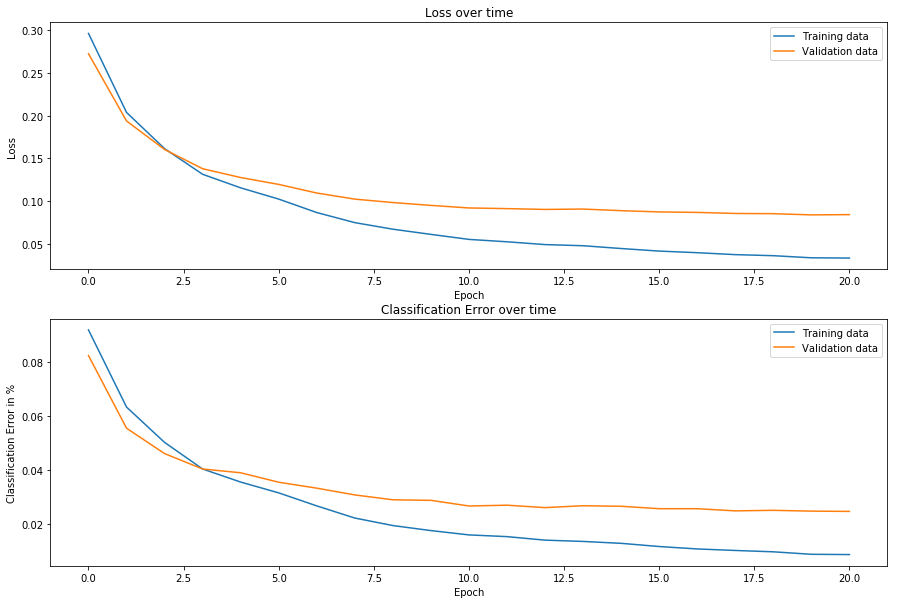

In [17]:
plot_training(train_results, save=False)

In [18]:
# compute final test error
test_error = nn.classification_error(X_test, y_test)
test_error

0.024